### Problem statement:
To build a CNN based  which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.



## Importing the data set:
Also import all the required libraries:

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import pathlib
import os
import PIL

import warnings
warnings.filterwarnings('ignore')

tf.get_logger().setLevel('ERROR')

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train anad test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
# Defining the path for train and test images

data_dir_train = pathlib.Path("/content/gdrive/My Drive/Melanoma Detection assignment/Train")
data_dir_test = pathlib.Path("/content/gdrive/My Drive/Melanoma Detection assignment/Test")

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))

print(image_count_train)
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

We will use 80% of the images for training and the rest 20% for validation.

In [ ]:
#Train dataset:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=32, image_size=(180,180), label_mode='categorical', seed=123,
                                                               subset='training', validation_split=0.2)



Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
#Validation dataset:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=32, image_size=(180,180), label_mode='categorical', seed=123,
                                                             validation_split=0.2, subset='validation')

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
# Creating a list of all class names i.e. types of skin cancers we are dealing with:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [ ]:
type(class_names)

list

# Visualizing the data:

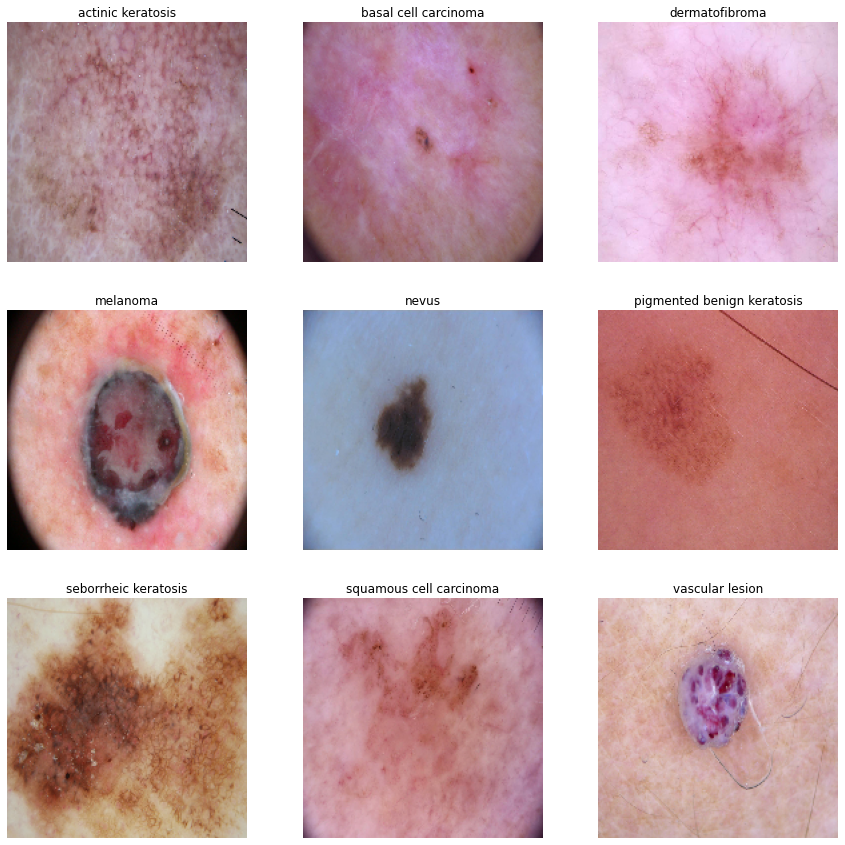

In [ ]:
from tensorflow.keras.preprocessing.image import load_img


img_path_dict={}

for c in class_names:
  img_path_dict[c] = list(map(lambda x: str(data_dir_train)+'/'+c+'/'+x, os.listdir(str(data_dir_train)+'/'+c)))


plt.figure(figsize=(15,15))
index = 0
for c in class_names:
  path_list = img_path_dict[c][:1]
  index += 1
  plt.subplot(3,3, index)
  plt.imshow(load_img(path_list[0], target_size=(180,180)))
  plt.title(c)
  plt.axis('off')

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
def class_distribution_count(directory):
    
    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))
    
    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]
    
    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,actinic keratosis,114
1,nevus,357
2,seborrheic keratosis,77
3,melanoma,438
4,vascular lesion,139
5,pigmented benign keratosis,462
6,basal cell carcinoma,376
7,dermatofibroma,95
8,squamous cell carcinoma,181


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 <a list of 9 Text major ticklabel objects>)

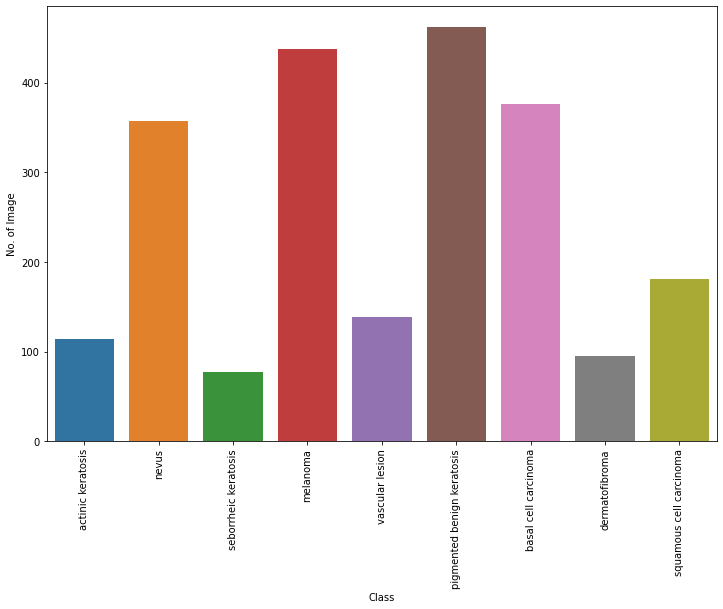

In [ ]:
#Visualizing no of images in each class:

import seaborn as sns
plt.figure(figsize=(12,8))
sns.barplot(y='No. of Image', x='Class', data=df, label='Class')
plt.xticks(rotation=90)

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [ ]:
#Sequential allows us to create /network layer by layer.

from tensorflow.keras.models import Sequential
cnn = Sequential()

#Rescaling the layer.
cnn.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180,180,3)))

# First convolutional and Pooling layer:
cnn.add(layers.Conv2D(16, kernel_size=(3,3), activation='relu'))
cnn.add(layers.MaxPool2D(pool_size=(2,2)))

# Second convolutional and Pooling layer:
cnn.add(layers.Conv2D(32, kernel_size=(3,3), activation='relu'))
cnn.add(layers.MaxPool2D(pool_size=(2,2)))

# Third Convolutional and Pooling layer:
cnn.add(layers.Conv2D(64, kernel_size=(3,3), activation='relu'))
cnn.add(layers.MaxPool2D(pool_size=(2,2)))


#Creating a flattening layer:
cnn.add(layers.Flatten())


# Creating a dense layer:
cnn.add(layers.Dense(128, activation='relu'))

#Creating a dense layer with softmax activation function. Softmax will scale outputs into probabilities:
cnn.add(layers.Dense(len(class_names), activation='softmax'))

cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 64)        1

In [ ]:
## Compiling the :
cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 64)        1

In [ ]:
## Training the : (We will take 20 epochs):
history = cnn.fit(train_ds, validation_data=val_ds, epochs=20)

Epoch 1/20
56/56 [==============================] - 706s 3s/step - loss: 1.9426 - accuracy: 0.2785 - val_loss: 1.8913 - val_accuracy: 0.2998
Epoch 2/20
56/56 [==============================] - 1s 22ms/step - loss: 1.6739 - accuracy: 0.4018 - val_loss: 1.6030 - val_accuracy: 0.4183
Epoch 3/20
56/56 [==============================] - 1s 22ms/step - loss: 1.4870 - accuracy: 0.4760 - val_loss: 1.4671 - val_accuracy: 0.4877
Epoch 4/20
56/56 [==============================] - 1s 22ms/step - loss: 1.3777 - accuracy: 0.5100 - val_loss: 1.4343 - val_accuracy: 0.4966
Epoch 5/20
56/56 [==============================] - 1s 20ms/step - loss: 1.3604 - accuracy: 0.5195 - val_loss: 1.4526 - val_accuracy: 0.5078
Epoch 6/20
56/56 [==============================] - 1s 20ms/step - loss: 1.2079 - accuracy: 0.5731 - val_loss: 1.3398 - val_accuracy: 0.5280
Epoch 7/20
56/56 [==============================] - 1s 20ms/step - loss: 1.0964 - accuracy: 0.6088 - val_loss: 1.3828 - val_accuracy: 0.5414
Epoch 8/20
56

## Visualizing training results:

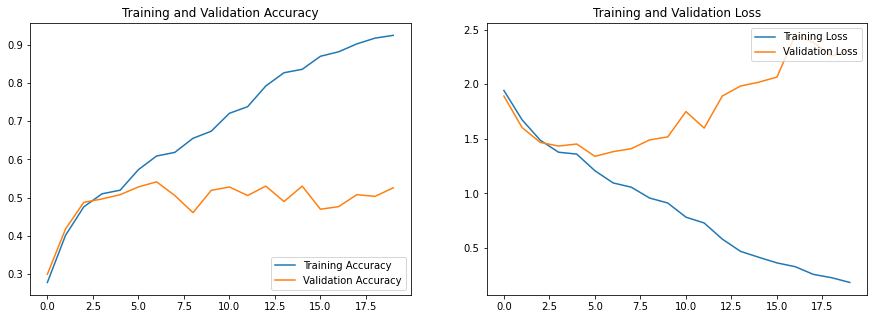

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

As we can see from the above graphs, we have got the training accuracy of about 92.41% and the validatin accuracy is 52.57%. This network that we have is clearly overfitting the data.

We can also see that the training loss reduces drastically however the validation loss, after decreasing for some epochs, starts increasing again.

In [ ]:
# Let's see if doing any data augmentation helps our  performance imporve:

augmentation = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal', input_shape=(180,180,3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1)
])

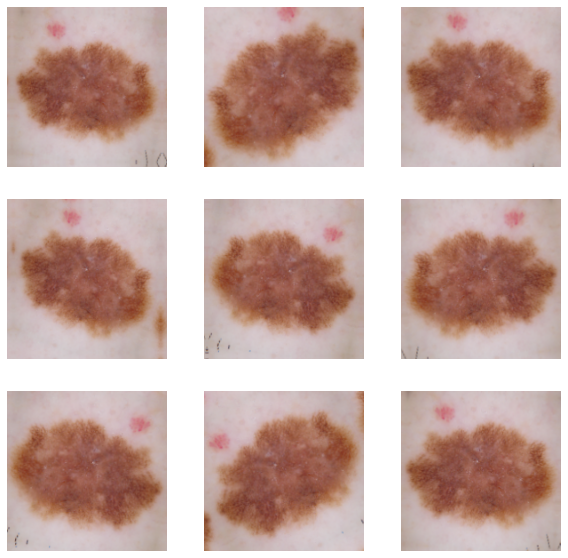

In [ ]:
# Let's see if our augmentation is was successful:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_image = augmentation(images)
    ax = plt.subplot(3,3,i+1)
    plt.imshow(augmented_image[0].numpy().astype('uint8'))
    plt.axis('off')

In [ ]:
#Now Let's creating the model again:

num_classes=9

cnn = Sequential([
  augmentation,

  layers.experimental.preprocessing.Rescaling(1./255),

  layers.Conv2D(16, 3, activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  
  layers.Dropout(0.2),
  
  layers.Flatten(),
  
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])


In [ ]:
#Compiling the model:
cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


#Training the model:
history = cnn.fit(train_ds, validation_data=val_ds, epochs=20)

Epoch 1/20
56/56 [==============================] - 15s 175ms/step - loss: 2.0448 - accuracy: 0.2366 - val_loss: 1.9198 - val_accuracy: 0.3110
Epoch 2/20
56/56 [==============================] - 9s 167ms/step - loss: 1.8369 - accuracy: 0.3298 - val_loss: 1.7165 - val_accuracy: 0.4183
Epoch 3/20
56/56 [==============================] - 9s 153ms/step - loss: 1.6427 - accuracy: 0.4302 - val_loss: 1.4928 - val_accuracy: 0.5145
Epoch 4/20
56/56 [==============================] - 9s 153ms/step - loss: 1.4552 - accuracy: 0.4978 - val_loss: 1.4141 - val_accuracy: 0.5123
Epoch 5/20
56/56 [==============================] - 9s 165ms/step - loss: 1.4150 - accuracy: 0.4989 - val_loss: 1.4573 - val_accuracy: 0.5145
Epoch 6/20
56/56 [==============================] - 8s 146ms/step - loss: 1.3788 - accuracy: 0.5151 - val_loss: 1.3771 - val_accuracy: 0.5324
Epoch 7/20
56/56 [==============================] - 9s 158ms/step - loss: 1.3116 - accuracy: 0.5268 - val_loss: 1.3461 - val_accuracy: 0.5414
Epoch

### Visualizing the results

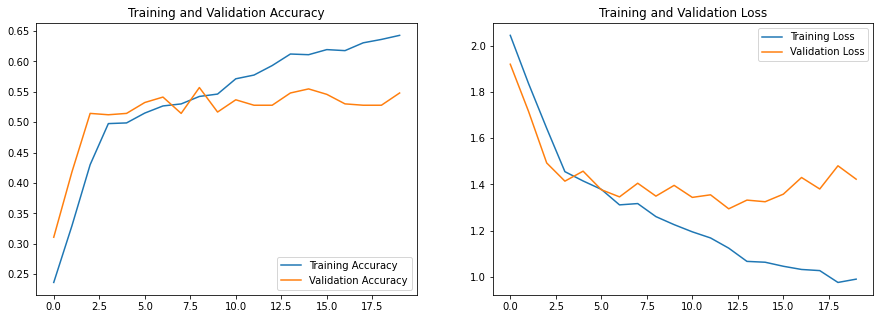

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

We can see, despit of not very impressive numbers, after data augmentation and introducing a dropout layer in our network, the bridge between the training and validation accuracy has been reduced. Same goes for the training and the validation loss.

After 20 epochs we got a trianing and validation accuracies of 64.29% and 54.81% respectively.

Also, the loss in the validation dataset is perceptibly decreasing.

## Finding the distribution of classes in the training dataset:

#### Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final  quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.


In [ ]:
## Your code goes here.
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(path_list)

2239

In [ ]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/My Drive/Melanoma Detection as...,actinic keratosis
1,/content/gdrive/My Drive/Melanoma Detection as...,actinic keratosis
2,/content/gdrive/My Drive/Melanoma Detection as...,actinic keratosis
3,/content/gdrive/My Drive/Melanoma Detection as...,actinic keratosis
4,/content/gdrive/My Drive/Melanoma Detection as...,actinic keratosis
...,...,...
2234,/content/gdrive/My Drive/Melanoma Detection as...,squamous cell carcinoma
2235,/content/gdrive/My Drive/Melanoma Detection as...,squamous cell carcinoma
2236,/content/gdrive/My Drive/Melanoma Detection as...,squamous cell carcinoma
2237,/content/gdrive/My Drive/Melanoma Detection as...,squamous cell carcinoma


Class=0, n=114 (5.092%)
Class=4, n=357 (15.945%)
Class=6, n=77 (3.439%)
Class=3, n=438 (19.562%)
Class=8, n=139 (6.208%)
Class=5, n=462 (20.634%)
Class=1, n=376 (16.793%)
Class=2, n=95 (4.243%)
Class=7, n=181 (8.084%)


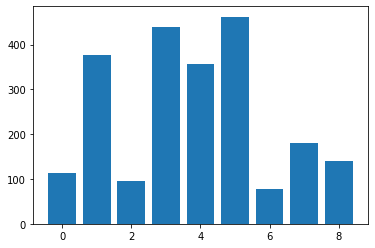

In [ ]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter
# split into input and output elements
X, y = original_df['Path'], original_df['Label']
# label encode the target variable
y = LabelEncoder().fit_transform(y)
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 <a list of 9 Text major ticklabel objects>)

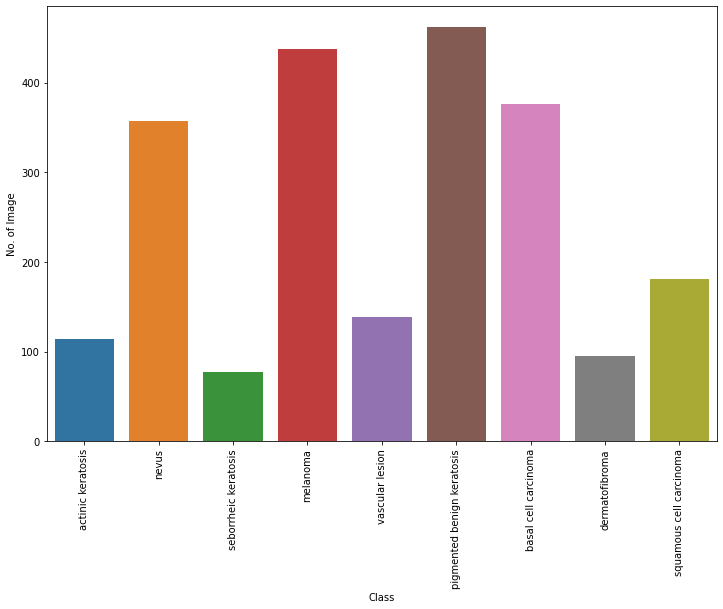

In [ ]:
# Looking at the distribution of each classes:
import seaborn as sns
plt.figure(figsize=(12,8))
sns.barplot(y='No. of Image', x='Class', data=df, label='Class')
plt.xticks(rotation=90)

-Q: Which class has the least number of samples?

- Ans: As we can see that the class-seborrheic keratosis has the lowest number of samples.


-Q: Which classes dominate the data in terms proportionate number of samples?

- Ans: The class-pigmented benign keratosis- has the maximum number of samples.

### Note:-
It is necessary for our training data to have at least some significant minimum number of records(images) in all the availabel classes in order to make sure that the  or our network has a sufficient, unbiased and equal amount of learning from all the classes.

In [ ]:
# Rectifying the class imbalance:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import glob

path_to_training_dataset="/content/gdrive/My Drive/Melanoma Detection assignment/Train/"

import Augmentor
for k in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + k)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) #Adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/My Drive/Melanoma Detection assignment/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FA0E7E83F10>: 100%|██████████| 500/500 [00:27<00:00, 18.19 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/My Drive/Melanoma Detection assignment/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA0E7E45640>: 100%|██████████| 500/500 [00:28<00:00, 17.67 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/My Drive/Melanoma Detection assignment/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA0E7F2BF70>: 100%|██████████| 500/500 [00:21<00:00, 23.27 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/My Drive/Melanoma Detection assignment/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=2592x1944 at 0x7FA0E7EDF310>: 100%|██████████| 500/500 [01:39<00:00,  5.05 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/My Drive/Melanoma Detection assignment/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7FA0E7E14D00>: 100%|██████████| 500/500 [01:36<00:00,  5.19 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/My Drive/Melanoma Detection assignment/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA0E7E02F10>: 100%|██████████| 500/500 [00:19<00:00, 25.15 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/My Drive/Melanoma Detection assignment/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FA0E7F03E20>: 100%|██████████| 500/500 [00:47<00:00, 10.57 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/My Drive/Melanoma Detection assignment/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA0E7F03580>: 100%|██████████| 500/500 [00:28<00:00, 17.84 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/My Drive/Melanoma Detection assignment/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA0E7F2A880>: 100%|██████████| 500/500 [00:22<00:00, 22.52 Samples/s]


The augmentor has stored the augmented images in the output sub-directory of each of the sub-directory of skin cancer type. Let's take a look at the total count of the augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


## Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/gdrive/My Drive/Melanoma Detection assignment/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030463.jpg_899cacf8-d003-4536-9226-ef93e4b2448b.jpg',
 '/content/gdrive/My Drive/Melanoma Detection assignment/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027562.jpg_8ff90457-b4f3-4b5b-b909-5b80a72f963b.jpg',
 '/content/gdrive/My Drive/Melanoma Detection assignment/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031292.jpg_51501366-2831-48a6-9cd2-2c7a891592a6.jpg',
 '/content/gdrive/My Drive/Melanoma Detection assignment/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0025992.jpg_b0f6fc10-4ee5-45e0-8863-b6703b5b4844.jpg',
 '/content/gdrive/My Drive/Melanoma Detection assignment/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027884.jpg_9da357e5-d6e1-43e8-8aad-d299932c7b8b.jpg',
 '/content/gdrive/My Drive/Melanoma Detection assignment/Train/actinic keratosis/output/actinic keratosis_original_ISIC_00283

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [ ]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

## Train the  on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
## Creating a training dataset:

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training', ## Todo choose the correct parameter value, so that only training data is refered to
  image_size=(img_height, img_width), label_mode='categorical',
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


## Creating a validation dataset:

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(180, 180), label_mode='categorical',
  batch_size=32)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

cnn=Sequential()

cnn.add(layers.experimental.preprocessing.Rescaling(1./255))
cnn.add(layers.Conv2D(16, kernel_size=(3,3), activation='relu'))
cnn.add(layers.MaxPool2D(pool_size=(2,2)))

cnn.add(layers.Conv2D(32, kernel_size=(3,3), activation='relu'))
cnn.add(layers.MaxPool2D(pool_size=(2,2)))

cnn.add(layers.Conv2D(64, kernel_size=(3,3), activation='relu'))
cnn.add(layers.MaxPool2D(pool_size=(2,2)))

cnn.add(layers.Dropout(0.2))

cnn.add(layers.Flatten())

cnn.add(layers.Dense(128, activation='relu'))
cnn.add(layers.Dense(len(class_names), activation='softmax'))

cnn.build(input_shape=(None, 180, 180, 3))
cnn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 178, 178, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 89, 89, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 87, 87, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 43, 43, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 41, 41, 64)       

In [ ]:
#compiling the model:
cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 178, 178, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 89, 89, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 87, 87, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 43, 43, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 41, 41, 64)       

In [ ]:
#Training the model:
## Your code goes here, use 50 epochs.

history = cnn.fit(train_ds, validation_data=val_ds, epochs=50)


Epoch 1/50
169/169 [==============================] - 40s 67ms/step - loss: 1.8538 - accuracy: 0.2964 - val_loss: 1.6927 - val_accuracy: 0.3534
Epoch 2/50
169/169 [==============================] - 4s 26ms/step - loss: 1.4239 - accuracy: 0.4624 - val_loss: 1.3035 - val_accuracy: 0.5011
Epoch 3/50
169/169 [==============================] - 5s 28ms/step - loss: 1.2429 - accuracy: 0.5406 - val_loss: 1.1699 - val_accuracy: 0.5776
Epoch 4/50
169/169 [==============================] - 4s 26ms/step - loss: 1.0673 - accuracy: 0.6066 - val_loss: 1.0108 - val_accuracy: 0.6333
Epoch 5/50
169/169 [==============================] - 4s 26ms/step - loss: 0.9582 - accuracy: 0.6556 - val_loss: 0.9281 - val_accuracy: 0.6622
Epoch 6/50
169/169 [==============================] - 5s 29ms/step - loss: 0.7692 - accuracy: 0.7237 - val_loss: 0.9679 - val_accuracy: 0.6719
Epoch 7/50
169/169 [==============================] - 4s 26ms/step - loss: 0.6841 - accuracy: 0.7528 - val_loss: 0.9117 - val_accuracy: 0.698

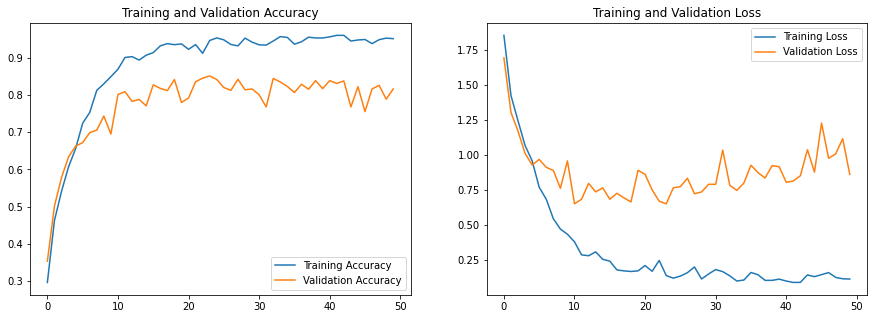

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(50)

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

After handling the class imbalance, we have finally got a CNN model with a training accuracy of 95.98% and a validation accuracy of 83.74%.


Also, the loss in the validation dataset was not able to converge well.


We can say that after handling Class imbalance, we did not fully got rid og the overfitting. However, the training and the validation accuracy we got are impressive compared to what we got earlier.



- 1st Model (raw model): This model was clearly overfitting.

  - Train Accuracy - 92.41%
  - Validation Accuracy - 52.57%



- 2nd model (after data augmentation): This model helped to reduce the huge gap between the training and the testing accuracy with not much impressive numbers.

  - Training Accuracy - 64.29%
  - Validation Accuracy - 54.81%
  


- 3rd model (after handling class imbalance): This model gave good training and validation accuracy but we did not fully got rid of overfitting.

  - Training Accuracy - 95.09%
  - Validation Accuracy - 81.59%
  